In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

The goal of this notebook is to explore underfitting and overfitting in Tensorflow. Intuitively we'd expect the accuracy of any model on the validation data would peak after training for a number of epochs and then start decreasing. This turning point is when our model begins to overfit the training data. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing data (or data they haven't seen before).

The opposite of overfitting is underfitting. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

To prevent overfitting, the best solution is to use more training data. If that's not possible, the the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook we'll explore two common regularization techniques -- weight regularization and dropout -- and use them to improve both IMDB movie review classification as well as MNIST classification

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


## Download the IMDB dataset
We will use a multi-hot-encoding of the sentences of these reviews. Multi-hot-encoding our lists means turning them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones.

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

17465344/17464789 [==============================] - 2s 0us/step


The word indicies are sorted by frequency, so we can expect that there are more 1-values near index zero as seen below

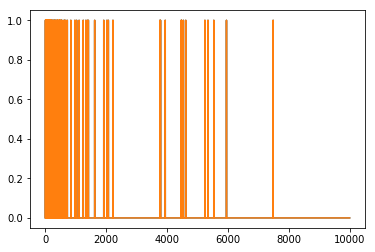

In [4]:
plt.plot(train_data[0])
plt.show()

## Demonstrate overfitting
The simplest way to prevent overfitting is to reduce the model size (i.e. number of parameters (hidden layers / # hidden units per layer)). This is equivalent to reducing the model's capacity.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss. We'll create a simple model using only Dense layers as a baseline, then create smaller and larger versions, and compare them.

### Baseline Model

In [5]:
#Define baseline graph architecture
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works. 
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

#Compile optimizer
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Fit the model with batch size 512 and multiple epochs
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 12s - loss: 0.4896 - acc: 0.8048 - binary_crossentropy: 0.4896 - val_loss: 0.3418 - val_acc: 0.8734 - val_binary_crossentropy: 0.3418
Epoch 2/20
 - 11s - loss: 0.2545 - acc: 0.9099 - binary_crossentropy: 0.2545 - val_loss: 0.2859 - val_acc: 0.8866 - val_binary_crossentropy: 0.2859
Epoch 3/20
 - 12s - loss: 0.1882 - acc: 0.9348 - binary_crossentropy: 0.1882 - val_loss: 0.2862 - val_acc: 0.8864 - val_binary_crossentropy: 0.2862
Epoch 4/20
 - 12s - loss: 0.1506 - acc: 0.9493 - binary_crossentropy: 0.1506 - val_loss: 0.3064 - val_acc: 0.8804 - val_binary_crossentropy: 0.3064
Epoch 5/20
 - 12s - loss: 0.1232 - acc: 0.9595 - binary_crossentropy: 0.1232 - val_loss: 0.3295 - val_acc: 0.8752 - val_binary_crossentropy: 0.3295
Epoch 6/20
 - 13s - loss: 0.0983 - acc: 0.9698 - binary_crossentropy: 0.0983 - val_loss: 0.3577 - val_acc: 0.8714 - val_binary_crossentropy: 0.3577
Epoch 7/20
 - 12s - loss: 0.0760 - acc: 0.9789 - binary_crosse

### Create a smaller model 

In [9]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [10]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 11s - loss: 0.6343 - acc: 0.6580 - binary_crossentropy: 0.6343 - val_loss: 0.5792 - val_acc: 0.7576 - val_binary_crossentropy: 0.5792
Epoch 2/20
 - 10s - loss: 0.5290 - acc: 0.8098 - binary_crossentropy: 0.5290 - val_loss: 0.5176 - val_acc: 0.8227 - val_binary_crossentropy: 0.5176
Epoch 3/20
 - 11s - loss: 0.4689 - acc: 0.8690 - binary_crossentropy: 0.4689 - val_loss: 0.4824 - val_acc: 0.8410 - val_binary_crossentropy: 0.4824
Epoch 4/20
 - 11s - loss: 0.4272 - acc: 0.8993 - binary_crossentropy: 0.4272 - val_loss: 0.4585 - val_acc: 0.8680 - val_binary_crossentropy: 0.4585
Epoch 5/20
 - 10s - loss: 0.3958 - acc: 0.9205 - binary_crossentropy: 0.3958 - val_loss: 0.4445 - val_acc: 0.8759 - val_binary_crossentropy: 0.4445
Epoch 6/20
 - 10s - loss: 0.3695 - acc: 0.9348 - binary_crossentropy: 0.3695 - val_loss: 0.4340 - val_acc: 0.8775 - val_binary_crossentropy: 0.4340
Epoch 7/20
 - 11s - loss: 0.3448 - acc: 0.9456 - binary_crosse

### Create a bigger model

In [11]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [12]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 29s - loss: 0.3441 - acc: 0.8525 - binary_crossentropy: 0.3441 - val_loss: 0.2979 - val_acc: 0.8786 - val_binary_crossentropy: 0.2979
Epoch 2/20
 - 26s - loss: 0.1418 - acc: 0.9476 - binary_crossentropy: 0.1418 - val_loss: 0.3378 - val_acc: 0.8734 - val_binary_crossentropy: 0.3378
Epoch 3/20
 - 27s - loss: 0.0459 - acc: 0.9862 - binary_crossentropy: 0.0459 - val_loss: 0.4486 - val_acc: 0.8677 - val_binary_crossentropy: 0.4486
Epoch 4/20
 - 27s - loss: 0.0073 - acc: 0.9987 - binary_crossentropy: 0.0073 - val_loss: 0.5914 - val_acc: 0.8681 - val_binary_crossentropy: 0.5914
Epoch 5/20
 - 26s - loss: 0.0013 - acc: 1.0000 - binary_crossentropy: 0.0013 - val_loss: 0.6679 - val_acc: 0.8698 - val_binary_crossentropy: 0.6679
Epoch 6/20
 - 27s - loss: 2.3461e-04 - acc: 1.0000 - binary_crossentropy: 2.3461e-04 - val_loss: 0.7120 - val_acc: 0.8708 - val_binary_crossentropy: 0.7120
Epoch 7/20
 - 31s - loss: 1.3338e-04 - acc: 1.0000 - b

## Plot the training and validation loss
The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model). Here, the smaller network begins overfitting later than the baseline model (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting. 

Note that the larger network overfits after just one epoch and overfits more severly

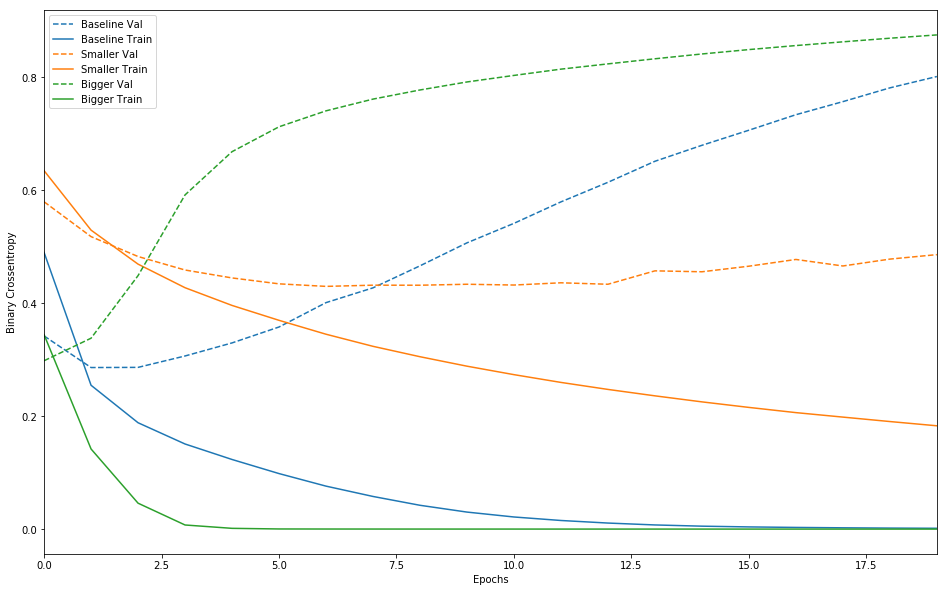

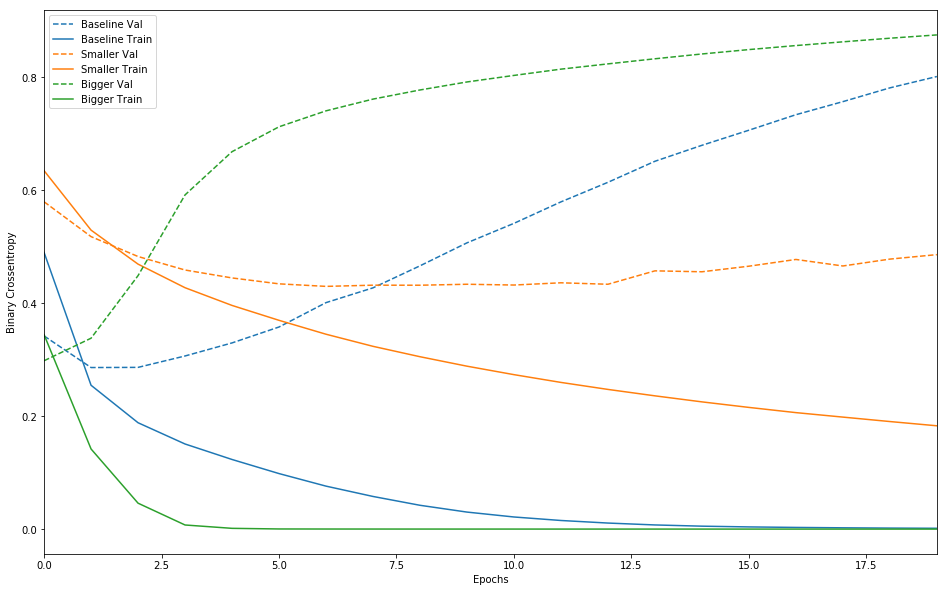

In [15]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

plt.show()

## Strategies
### Add weight regularization
We're aiming to create a simpler model where the distribution of parameter values has less entropy (or fewer parameters altogether). We can mitigate overfitting by forcing a network's weights to only take small values which makes the distribution of weights more "regular" -- aka weight regularization. To do this, we add a term to the loss function that penalizes larger weights.

- L1:  where the cost added is proportional to the absolute value of weights' coefficients
- L2: the cost added is proportional to the square of the value of the weights' coefficients. This is also known as weight decay in the context of neural networks. 

We'll add L2 regularization below -- every coefficient in the weight matrix of the layer will have loss + 0.001*(coefficient)**2 

In [13]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 11s - loss: 0.5227 - acc: 0.8093 - binary_crossentropy: 0.4811 - val_loss: 0.3803 - val_acc: 0.8780 - val_binary_crossentropy: 0.3364
Epoch 2/20
 - 10s - loss: 0.3034 - acc: 0.9093 - binary_crossentropy: 0.2549 - val_loss: 0.3381 - val_acc: 0.8872 - val_binary_crossentropy: 0.2864
Epoch 3/20
 - 10s - loss: 0.2538 - acc: 0.9308 - binary_crossentropy: 0.1997 - val_loss: 0.3393 - val_acc: 0.8859 - val_binary_crossentropy: 0.2833
Epoch 4/20
 - 10s - loss: 0.2310 - acc: 0.9408 - binary_crossentropy: 0.1734 - val_loss: 0.3509 - val_acc: 0.8814 - val_binary_crossentropy: 0.2923
Epoch 5/20
 - 10s - loss: 0.2182 - acc: 0.9457 - binary_crossentropy: 0.1583 - val_loss: 0.3657 - val_acc: 0.8785 - val_binary_crossentropy: 0.3050
Epoch 6/20
 - 10s - loss: 0.2091 - acc: 0.9488 - binary_crossentropy: 0.1474 - val_loss: 0.3796 - val_acc: 0.8760 - val_binary_crossentropy: 0.3173
Epoch 7/20
 - 11s - loss: 0.2029 - acc: 0.9522 - binary_crosse

Now we'll view the impact of the L2 penalty

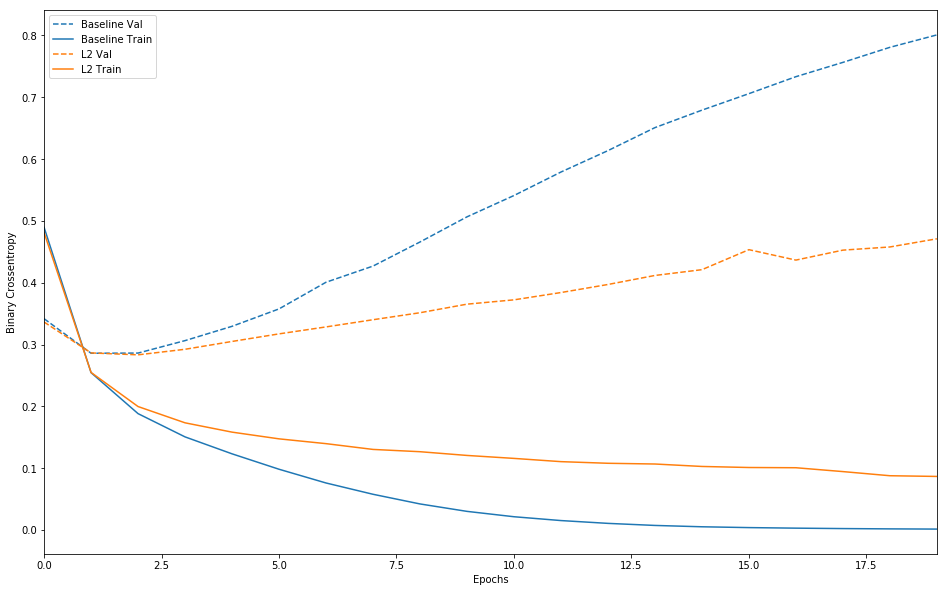

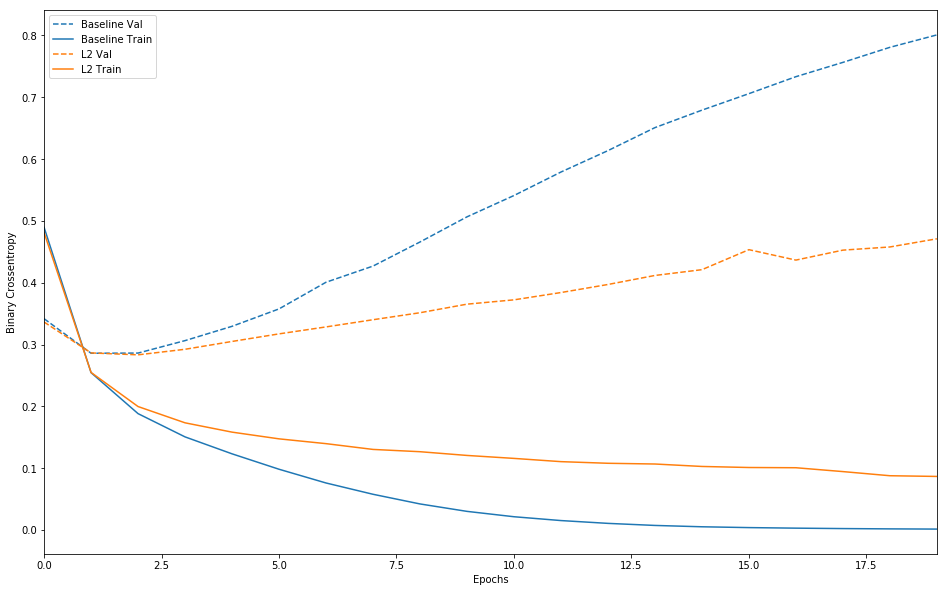

In [17]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

plt.show()


### Dropout
Dropout consists of randomly dropping out a number of output features of a layer during training. The dropout rate is the fraction of features that are set to 0 (typically 0.2-0.5). At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, to balance out the fact that more units are active during training.

e'll add two Dropout layers to our IMDB network to see how well they do at reducing overfitting

In [ ]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 13s - loss: 0.6201 - acc: 0.6508 - binary_crossentropy: 0.6201 - val_loss: 0.4891 - val_acc: 0.8554 - val_binary_crossentropy: 0.4891
Epoch 2/20
 - 12s - loss: 0.4665 - acc: 0.7900 - binary_crossentropy: 0.4665 - val_loss: 0.3568 - val_acc: 0.8815 - val_binary_crossentropy: 0.3568
Epoch 3/20
 - 11s - loss: 0.3752 - acc: 0.8478 - binary_crossentropy: 0.3752 - val_loss: 0.2993 - val_acc: 0.8898 - val_binary_crossentropy: 0.2993
Epoch 4/20
 - 12s - loss: 0.3171 - acc: 0.8794 - binary_crossentropy: 0.3171 - val_loss: 0.2771 - val_acc: 0.8914 - val_binary_crossentropy: 0.2771
Epoch 5/20
 - 10s - loss: 0.2750 - acc: 0.8976 - binary_crossentropy: 0.2750 - val_loss: 0.2804 - val_acc: 0.8864 - val_binary_crossentropy: 0.2804
Epoch 6/20
 - 11s - loss: 0.2369 - acc: 0.9120 - binary_crossentropy: 0.2369 - val_loss: 0.2787 - val_acc: 0.8880 - val_binary_crossentropy: 0.2787
Epoch 7/20
 - 11s - loss: 0.2101 - acc: 0.9227 - binary_crosse

In [ ]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])